In [1]:
import numpy as np
import torch
from torch import nn

import nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.coupling import AdditiveCouplingTransform, AffineCouplingTransform
from nflows.transforms.base import CompositeTransform
import matplotlib.pyplot as plt

from neulat.action import Phi4Action
from loss import ReparamKL
from neulat.models import Z2Nice, COUPLINGS

from tqdm import tqdm

import matplotlib.pyplot as plt 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
T, L = 16, 8
lattice_shape = (T,L)

In [4]:
kappa = 0.3
lambd = 0.022
phi4_action = Phi4Action(kappa, lambd)

### Define flow in nflows

In [5]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker

In [6]:
make_checker_mask(lattice_shape, 0)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)

In [7]:
def make_mask(lattice_shape, parity):
    """
    Input: B x T, flattened 8*8
    """
    mask = make_checker_mask(lattice_shape, parity)
    return mask.flatten()

In [8]:
make_mask(lattice_shape, 0) + make_mask(lattice_shape, 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)

In [9]:
class Net(nn.Module):
    def __init__(self, num_id, num_trf) -> None:
        super().__init__()
        mid_dim=1000
        nblocks=4

        self.net = nn.Sequential(
            nn.Linear(num_id, mid_dim, bias=False),
            nn.Tanh(),
            nn.Sequential(*[
                nn.Sequential(
                    nn.Linear(mid_dim, mid_dim, bias=False),
                    nn.Tanh(),
                ) for _ in range(nblocks)
            ]),
            nn.Linear(mid_dim, num_trf, bias=False)
        )
    
    def forward(self, x, ctx):
        return self.net(x)

In [10]:
class Z2NICE(AdditiveCouplingTransform):
    def __init__(self, mask, transform_net_create_fn, unconditional_transform=None, scale_activation=...):
        super().__init__(mask, transform_net_create_fn, unconditional_transform, scale_activation)

        self.scale = nn.Parameter(
            torch.zeros((1, torch.tensor(list(lattice_shape)).prod()//2)),
            requires_grad=True
        )

    def _scale_and_shift(self, transform_params):
        shift = transform_params
        scale = torch.exp(self.scale)
        return scale, shift

In [11]:
num_layers = 6
base_dist = StandardNormal(shape=[128]).to(device)

transforms = []
for i in range(num_layers):
    transforms.append(
        Z2NICE(
            make_mask(lattice_shape, i % 2), 
            Net
        ),
    )
transform = CompositeTransform(transforms)

flow_nflows = Flow(transform, base_dist)

In [12]:
coupling_factory = COUPLINGS["checkerfc"]
flow_neulat = Z2Nice(
    lat_shape=lattice_shape,
    coupling_factory=coupling_factory,
    ncouplings=6,
    nblocks=4,
    global_scaling=False
)

### Training

In [13]:
flow = flow_nflows
flow = flow.to(device)

In [14]:
kl_loss = ReparamKL(
    model=flow, 
    action=phi4_action, 
    lat_shape=lattice_shape,
    batch_size=20_000
)

In [15]:
def train_step(model, action, optimizer):
    
    optimizer.zero_grad()

    loss, loss_summands, actions = kl_loss()
    
    loss.backward()
    optimizer.step()
    
    print("loss", loss.cpu().item())

    return loss.cpu().item()

In [16]:
losses = []

In [42]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=4e-6, amsgrad=True)
for epoch in range(100):
    print(epoch)
    loss = train_step(flow_nflows, phi4_action, optimizer)
    losses.append(loss)

0
loss -133.62335205078125
1
loss -133.6060791015625
2
loss -133.62391662597656
3
loss -133.61863708496094
4
loss -133.62069702148438
5
loss -133.6200408935547
6
loss -133.64463806152344
7
loss -133.63333129882812
8
loss -133.61972045898438
9
loss -133.64596557617188
10
loss -133.61341857910156
11
loss -133.62884521484375
12
loss -133.62425231933594
13
loss -133.6189727783203
14
loss -133.6300506591797
15
loss -133.6457061767578
16
loss -133.6299285888672
17
loss -133.6389923095703
18
loss -133.6471405029297
19
loss -133.6358642578125
20
loss -133.62120056152344
21
loss -133.62045288085938
22
loss -133.64476013183594
23
loss -133.61624145507812
24
loss -133.6324462890625
25
loss -133.63453674316406
26
loss -133.638671875
27
loss -133.66539001464844
28
loss -133.63681030273438
29
loss -133.6185760498047
30
loss -133.64537048339844
31
loss -133.65899658203125
32
loss -133.64761352539062
33
loss -133.6377716064453
34
loss -133.61038208007812
35
loss -133.64308166503906
36
loss -133.631332

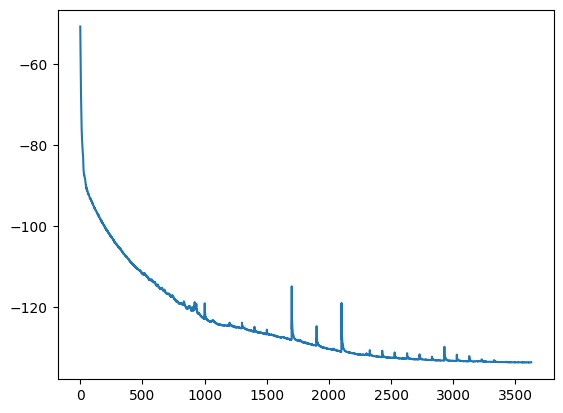

In [43]:
plt.plot(losses)

In [19]:
torch.save(flow.state_dict(), "model_nflows.pth")